# Full MNIST exercise
Here is where I try to run the full exercise of classifying the MNIST dataset!

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [3]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

## Get the data
Should be fairly simple to get the data from the built in tools :)

In [4]:
path = untar_data(URLs.MNIST)

In [5]:
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/testing'),Path('/root/.fastai/data/mnist_png/training')]

In [6]:
(path/'training'/'9').ls()

(#5949) [Path('/root/.fastai/data/mnist_png/training/9/26612.png'),Path('/root/.fastai/data/mnist_png/training/9/36181.png'),Path('/root/.fastai/data/mnist_png/training/9/23617.png'),Path('/root/.fastai/data/mnist_png/training/9/5874.png'),Path('/root/.fastai/data/mnist_png/training/9/58112.png'),Path('/root/.fastai/data/mnist_png/training/9/53370.png'),Path('/root/.fastai/data/mnist_png/training/9/32878.png'),Path('/root/.fastai/data/mnist_png/training/9/31325.png'),Path('/root/.fastai/data/mnist_png/training/9/23329.png'),Path('/root/.fastai/data/mnist_png/training/9/30987.png')...]

In [7]:
Image.open((path/'training'/'5').ls().sorted()[0])

## Baseline
As suggested in the `04_mnist_basics` notebook, we need a baseline model. I will use the same "pixel similarity" approach as used there.

In [8]:
def loadData(kind, number):
  '''
  load data of a given kind (training/validation) for a given number
  '''

  data = (path/kind/str(number)).ls().sorted()

  tensors = [ tensor(Image.open(o)) for o in data ]

  stack = torch.stack(tensors).float()/225

  return stack

In [9]:
numbers = range(10)

In [10]:
train_data = {}
valid_data = {}
for k in numbers:
  train_data[k] = loadData('training', k)
  valid_data[k] = loadData('testing', k)

In [11]:
train_data.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [12]:
pd.DataFrame((train_data[6][0]*255).int()).style.set_properties(**{'font_size': '6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,165,289,184,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,91,286,286,286,34,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,11,0,0,0,0,0,0,0,123,259,286,286,227,15,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,128,0,0,0,0,0,0,55,258,286,286,277,95,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,39,257,286,286,275,97,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,29,165,286,286,274,98,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,9,211,286,286,286,177,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,9,164,286,286,286,206,20,0,0,0,0,0,0,0,0,0,0,0,0


Get the average for each number:

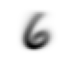

In [13]:
average_num = {}
for k in numbers:
  average_num[k] = train_data[k].mean(0)

show_image(average_num[6])

Let's see how a given image from the validation set behaves against all the average numbers. First let's define a "distance metric"

In [14]:
test_image = valid_data[4][0]
test_image.shape

torch.Size([28, 28])

In [15]:
### it automatically runs the reduction (i.e. the mean) on all the dimensions, thus killing the broadcast
def error(a, b):
  return F.mse_loss(a,b).sqrt()

In [16]:
def myerror(a,b):
  return ((a-b)**2).mean((-1,-2)).sqrt()

In [17]:
myerror(test_image, average_num[4])

tensor(0.2995)

In [18]:
for i in numbers:
  print(f'test image vs average {i} --> error = {myerror(test_image, average_num[i]):.4f}')

test image vs average 0 --> error = 0.3911
test image vs average 1 --> error = 0.4125
test image vs average 2 --> error = 0.3803
test image vs average 3 --> error = 0.3565
test image vs average 4 --> error = 0.2995
test image vs average 5 --> error = 0.3430
test image vs average 6 --> error = 0.3670
test image vs average 7 --> error = 0.3210
test image vs average 8 --> error = 0.3484
test image vs average 9 --> error = 0.3166


Classify an image as the number giving the lower RMSE:

In [19]:
valid_data[4].shape

torch.Size([982, 28, 28])

In [20]:
average_num[4].shape

torch.Size([28, 28])

In [21]:
err = myerror(valid_data[4], average_num[4])
err.shape, err[:10]

(torch.Size([982]),
 tensor([0.2995, 0.2421, 0.3095, 0.2632, 0.2615, 0.2359, 0.2923, 0.2102, 0.2788, 0.3657]))

In [22]:
def getNumber(x):

  errors = torch.stack([ myerror(x, average_num[i]) for i in numbers ])

  return torch.argmin(errors,0)

Simply test it on `test_image`:

In [23]:
getNumber(test_image)

tensor(4)

In [24]:
valid_data[4].shape

torch.Size([982, 28, 28])

In [25]:
pred = getNumber(valid_data[4])
pred.shape, pred[:20]

(torch.Size([982]),
 tensor([4, 9, 4, 8, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 6, 4, 4, 4, 4]))

In [26]:
(pred == 4).float().mean()

tensor(0.8259)

In this case we have a multi-class problem, so the final classification is different wrt/ to the "3 vs 7" problem. Let's compute the accuracy for every number in the usual way, i.e. fraction of true "N" classified as "N" and then take the average:

In [27]:
accuracies = [ (getNumber(valid_data[i])==i).float().mean() for i in numbers  ]
len(accuracies), accuracies

(10,
 [tensor(0.8959),
  tensor(0.9621),
  tensor(0.7568),
  tensor(0.8059),
  tensor(0.8259),
  tensor(0.6861),
  tensor(0.8633),
  tensor(0.8327),
  tensor(0.7372),
  tensor(0.8067)])

In [28]:
print('overall accuracy:', torch.stack(accuracies).mean().item())

overall accuracy: 0.8172568082809448


## Build the ML model
Here I try to adopt a compromise between building everything from scratch (as it is done in the notebook from the course) and using everything from `fastai`/`pytorch`.

### Manipulate data
First of all, manipulate the data to build the dataset (and then the data loaders):
* put all the data in a single tensor and transform every image in a vector
* get the proper labels
* create datasets
* store into a `DataLoaders`

All of the above for both the training and the validation data

In [29]:
(train_data[0]).shape

torch.Size([5923, 28, 28])

In [30]:
train_x = torch.cat([ train_data[i] for i in numbers ]).view(-1, 28*28)
train_x.shape

torch.Size([60000, 784])

In [31]:
train_y = torch.cat([ tensor([i] * len(train_data[i])) for i in numbers ]).unsqueeze(1)
train_y.shape

torch.Size([60000, 1])

In [32]:
train_ds = list(zip(train_x,train_y))

In [33]:
x,y = train_ds[0]
x.shape,y.shape,y

(torch.Size([784]), torch.Size([1]), tensor([0]))

In [34]:
valid_x = torch.cat([valid_data[i] for i in numbers]).view(-1, 28*28)
valid_y = torch.cat([ tensor([i] * len(valid_data[i])) for i in numbers ]).unsqueeze(1)
valid_ds = list(zip(valid_x, valid_y))

In [35]:
doc(DataLoader)

In [36]:
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=256)

In [37]:
doc(DataLoaders)

In [38]:
dls = DataLoaders(train_dl, valid_dl)

In [39]:
len(dls.valid_ds)

10000

### Build the model
Here build the actual model and all the related stuff. There are a number of things to keep in mind:  
1) similarly to above, 10 different "output" numbers, are needed, one for each category

This means that the network will have 10 output units each representing the activation for each number. Here I want to use the same loss function as in the example, but some additional work is needed: first I encode the target in a 1-hot fashion and then use the same strategy as in the example.


In [40]:
def myloss(predictions, targets):

  if targets.ndim == 1:
    targets = targets.unsqueeze(1)
  
  targets_encoded = torch.zeros(len(targets), 10)
  targets_encoded.scatter_(1, targets, 1)

  return torch.where( targets_encoded==1, 1-predictions, predictions ).mean()

In [41]:
def mycrossentropy(predictions, targets):

  if targets.ndim > 1:
    targets = targets.squeeze()

  return F.cross_entropy(predictions, targets)

In [42]:
#t = 3
#pred = torch.tensor([0.1, 0.3, 0.2, 0.9, 0.1, 0.1, 0.2, 0.3, 0.2, 0.4])

labels = [3,4,0]
t = torch.tensor(labels).unsqueeze(1)
pred = torch.stack([
                  torch.tensor([0.01, 0.05, 0.1, 0.8, 0.1, 0.2, 0.1, 0.05, 0.1, 0.1]),
                  torch.tensor([0.1, 0.15, 0.1, 0.1, 0.8, 0.2, 0.1, 0.05, 0.1, 0.1]),
                  torch.tensor([0.9, 0.15, 0.1, 0.1, 0.1, 0.2, 0.1, 0.05, 0.1, 0.1]),
])

In [43]:
pred.shape, t.shape, t

(torch.Size([3, 10]), torch.Size([3, 1]), tensor([[3],
         [4],
         [0]]))

In [44]:
t[0].ndim

1

In [45]:
t[0].shape, len(t[0]), t[0]

(torch.Size([1]), 1, tensor([3]))

In [46]:
m = []
for i in range(len(pred)):
  print(f'{i}-th entry: {myloss(pred[i], t[i])}')
  m.append(myloss(pred[i], t[i]))
print('mean:', np.mean(m))

0-th entry: 0.10099999606609344
1-th entry: 0.12000000476837158
2-th entry: 0.10999999940395355
mean: 0.11033333


In [47]:
myloss(pred, t)

tensor(0.1103)

In [48]:
mycrossentropy(pred, t)

tensor(1.6762)

Similar to above, we have to define the accuracy. Follow the same idea as in the baseline model:

In [49]:
def myaccuracy(predictions, targets):

  pred_nums = torch.argmax(predictions, axis=1)

  return (pred_nums==targets.T).float().mean()

In [50]:
p = torch.argmax(pred, axis=1)
p

tensor([3, 4, 0])

In [51]:
t

tensor([[3],
        [4],
        [0]])

In [52]:
p==t.T

tensor([[True, True, True]])

In [53]:
myaccuracy(pred, t)

tensor(1.)

In [54]:
model1 = nn.Sequential(
    nn.Linear(28*28, 50),
    nn.ReLU(),
    nn.Linear(50,10),
    nn.Sigmoid()
)

In [55]:
learn1 = Learner(dls, model1, loss_func=myloss, opt_func=SGD, metrics=myaccuracy)

In [56]:
model2 = nn.Sequential(
    nn.Linear(28*28, 50),
    nn.ReLU(),
    nn.Linear(50,10),
    nn.Sigmoid()
)

In [57]:
learn2 = Learner(dls, model2, loss_func=mycrossentropy, opt_func=SGD, metrics=myaccuracy)

Test on a few examples from the actual data:

In [58]:
train_x.shape

torch.Size([60000, 784])

In [59]:
batch_x = train_x[:5, :]
batch_y = train_y[:5]

In [60]:
batch_x.shape, batch_y.shape

(torch.Size([5, 784]), torch.Size([5, 1]))

In [64]:
batch_pred = model1(batch_x)
batch_pred.shape

torch.Size([5, 10])

In [65]:
batch_pred

tensor([[0.4839, 0.5135, 0.5599, 0.4853, 0.4992, 0.4857, 0.4819, 0.4586, 0.4695, 0.5523],
        [0.5104, 0.5378, 0.5643, 0.5025, 0.4922, 0.4757, 0.4911, 0.4839, 0.4733, 0.5423],
        [0.5139, 0.5060, 0.5848, 0.4939, 0.4770, 0.4866, 0.4601, 0.4926, 0.4642, 0.5707],
        [0.4725, 0.4916, 0.5879, 0.4957, 0.4974, 0.4373, 0.5408, 0.4555, 0.4482, 0.5123],
        [0.5129, 0.5034, 0.5481, 0.4939, 0.5040, 0.4810, 0.4968, 0.4834, 0.4599, 0.5322]], grad_fn=<SigmoidBackward>)

In [66]:
myloss(batch_pred, batch_y)

tensor(0.5016, grad_fn=<MeanBackward0>)

In [67]:
mycrossentropy(batch_pred, batch_y)

tensor(2.3058, grad_fn=<NllLossBackward>)

In [68]:
myaccuracy(batch_pred, batch_y)

tensor(0.)

In [69]:
#doc(nn.Linear)

In [70]:
learn1.fit(n_epoch=40, lr=0.05)

epoch,train_loss,valid_loss,myaccuracy,time
0,0.134218,0.113753,0.206600,00:01
1,0.106142,0.104607,0.241400,00:01
2,0.103172,0.102648,0.138100,00:01
3,0.102136,0.101829,0.115700,00:01
4,0.101583,0.101386,0.114000,00:01
5,0.101267,0.101111,0.113500,00:01
6,0.101039,0.100924,0.113500,00:01
7,0.100906,0.100789,0.113500,00:01
8,0.100759,0.100687,0.113500,00:01
9,0.100678,0.100608,0.113500,00:01


In [71]:
learn2.fit(n_epoch=40, lr=0.05)

epoch,train_loss,valid_loss,myaccuracy,time
0,2.090261,2.019460,0.764500,00:01
1,1.851998,1.814882,0.805300,00:01
2,1.759087,1.739469,0.814600,00:01
3,1.714519,1.698768,0.832100,00:01
4,1.687100,1.673648,0.840800,00:01
5,1.666821,1.656303,0.851700,00:01
6,1.653941,1.643401,0.849700,00:01
7,1.642127,1.632611,0.859300,00:01
8,1.633752,1.624147,0.859000,00:01
9,1.625924,1.616811,0.865200,00:01


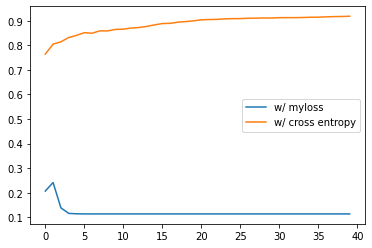

In [73]:
plt.plot(L(learn1.recorder.values).itemgot(2), label='w/ myloss');
plt.plot(L(learn2.recorder.values).itemgot(2), label='w/ cross entropy');

plt.legend(loc='best');

Check what is going on:

In [75]:
batch_y

tensor([[0],
        [0],
        [0],
        [0],
        [0]])

In [74]:
model1(batch_x)

tensor([[3.9737e-06, 2.3754e-05, 3.7458e-06, 2.1279e-06, 3.1777e-06, 4.1798e-06, 3.5480e-06, 4.4862e-06, 2.9011e-06, 3.1170e-06],
        [3.2510e-05, 1.5322e-04, 2.9165e-05, 2.1045e-05, 2.8467e-05, 3.2954e-05, 3.0909e-05, 3.4809e-05, 2.4691e-05, 2.8036e-05],
        [1.4162e-10, 4.1921e-09, 8.6994e-11, 4.9182e-11, 9.4531e-11, 1.4529e-10, 1.0986e-10, 2.0410e-10, 9.2959e-11, 7.7468e-11],
        [4.8831e-05, 1.5990e-04, 5.0114e-05, 2.7525e-05, 3.4216e-05, 3.3996e-05, 5.0872e-05, 4.6151e-05, 2.8764e-05, 2.9847e-05],
        [1.3763e-05, 6.3028e-05, 1.2435e-05, 8.1820e-06, 1.0536e-05, 1.3688e-05, 1.3276e-05, 1.5969e-05, 8.7765e-06, 1.0267e-05]], grad_fn=<SigmoidBackward>)

In [76]:
model2(batch_x)

tensor([[9.9997e-01, 1.9660e-10, 2.8802e-05, 7.1700e-05, 3.9799e-11, 2.1466e-04, 1.3326e-05, 1.7063e-04, 6.1224e-06, 5.6696e-06],
        [9.9806e-01, 7.7187e-10, 3.2351e-04, 1.9475e-05, 2.1741e-06, 1.4926e-01, 2.7456e-04, 2.0312e-05, 7.7267e-03, 9.0754e-05],
        [7.1219e-01, 4.2656e-10, 2.6540e-09, 6.5700e-04, 9.7222e-09, 4.9841e-04, 3.9048e-07, 5.9277e-09, 6.7378e-04, 6.5973e-07],
        [9.9956e-01, 7.8313e-11, 1.4271e-01, 1.7383e-03, 2.3370e-09, 2.2956e-05, 2.3185e-03, 1.6754e-06, 4.0645e-05, 7.0746e-09],
        [9.9985e-01, 4.5725e-10, 6.3417e-03, 1.8504e-04, 3.7823e-11, 1.4808e-04, 5.6004e-05, 4.3960e-06, 6.0555e-03, 2.3748e-04]], grad_fn=<SigmoidBackward>)